# Introduction
We will create a class of decision trees for classification by scratching. We will implement the algorithm using only the minimum library such as NumPy.


​In the learning of the decision tree, a hyperparameter called the (maximum) depth that indicates how many times the conditional branch is repeated appears, but the implementation of depth 1 is an essential assignment. Those with a depth of 2 or more are considered as advanced assignment.


There are various learning methods, but here we will implement based on the CART method, which is also used in scikit-learn.​ ​This method only splits the branch into two to reduce the complexity of learning.



In [17]:
# predefines and import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DISCLAIMER
- For problem 1 and 2, i created a somewhat 'naive' node class to serve for the calculation of gini score
- But the implementation is completely changed in problem 3 when i needed to adapt to the learning and estimation
- **So for the sake of clarity, there's no reason to review the Node class in prob 1 and 2**

# Problem 1
Function for finding impureness

In [18]:
# defining simple node and class
class Class():
    def __init__(self, n_samples):
        self.n_samples = n_samples
    def __str__(self):
        return f'Class:{self.n_samples}'
class Node():
    def __init__(self, *classes,left = None, right = None):
        self.classes = classes
        self.n_classes = len(classes)
        self.left = left
        self.right = right
    def total(self):
        return sum([c.n_samples for c in self.classes])
    def __str__(self):
        return f'Node - {self.n_classes} Classes: {[ f"{i}:{str(c)}"for i,c in enumerate(self.classes)]}'

In [19]:
def gini_impureness(node):
    total_sample_count = node.total()
    sum_squared_percentage = 0
    for i in range(node.n_classes):
        sum_squared_percentage += (node.classes[i].n_samples / total_sample_count) ** 2
    return 1 - sum_squared_percentage
def test_gini():
    n1 = Node(Class(15),Class(15))
    n2 = Node(Class(15),Class(15),Class(15))
    n3 = Node(Class(18),Class(12))
    n4 = Node(Class(30),Class(0))
    for n in [n1,n2,n3,n4]:
        print('---')
        print(str(n))
        print('gini-impureness: ', gini_impureness(n))
test_gini()

---
Node - 2 Classes: ['0:Class:15', '1:Class:15']
gini-impureness:  0.5
---
Node - 3 Classes: ['0:Class:15', '1:Class:15', '2:Class:15']
gini-impureness:  0.6666666666666667
---
Node - 2 Classes: ['0:Class:18', '1:Class:12']
gini-impureness:  0.48
---
Node - 2 Classes: ['0:Class:30', '1:Class:0']
gini-impureness:  0.0


# Problem 2
Function for finding information gain

In [20]:
# more complex node class
class Class():
    def __init__(self, n_samples, level = 0):
        self.n_samples = n_samples
        self.level = level
    def count(self): 
        return self.n_samples
    def __str__(self):
        return f' Class:{self.n_samples}'
class Node():
    def __init__(self, *children, level = 0):
        self.children = children # child can be node or class
        self.n_child = len(children)
        self.level = level
    def count(self):
        return sum([child.count() for child in self.children])
    def child(self,i):
        return self.children[i]
    def __str__(self):
        tabbing = '\t' * self.level
        start = f' Node - {self.n_child} children: \n'
        for child in self.children: child.level = self.level + 1
        end = [ f'{i}:{str(child)}'for i,child in enumerate(self.children) ]
        separator = tabbing + '|--'
        return start + separator + ('\n' + separator).join(end)

# updated gini impureness
def gini_impureness(node):
    total_sample_count = node.count()
    sum_squared_percentage = 0
    for i in range(node.n_child):
        sum_squared_percentage += (node.child(i).count() / total_sample_count)**2 
    return 1 - sum_squared_percentage

test_gini()

---
 Node - 2 children: 
|--0: Class:15
|--1: Class:15
gini-impureness:  0.5
---
 Node - 3 children: 
|--0: Class:15
|--1: Class:15
|--2: Class:15
gini-impureness:  0.6666666666666667
---
 Node - 2 children: 
|--0: Class:18
|--1: Class:12
gini-impureness:  0.48
---
 Node - 2 children: 
|--0: Class:30
|--1: Class:0
gini-impureness:  0.0


In [21]:
def gini_gain(parent):
    total_count = parent.count()
    information_loss = sum([
        child.count() / total_count * gini_impureness(child) 
        for child in parent.children])
        
    return gini_impureness(parent) - information_loss

parent_node = Node(
    Node(Class(10),Class(30)),
    Node(Class(20), Class(5)),
)


print('Parent Node: ', str(parent_node))
print('Gini Gain: ', gini_gain(parent_node))

Parent Node:   Node - 2 children: 
|--0: Node - 2 children: 
	|--0: Class:10
	|--1: Class:30
|--1: Node - 2 children: 
	|--0: Class:20
	|--1: Class:5
Gini Gain:  0.11952662721893492


### NOTE:
- in prob2 , the Information gain is actually Gini-Gain
- the example Left node class 1: Number of samples 10, Left node class 2: Number of samples 30, Right node class 1: Number of samples 20, Right node class 2: Number of samples 5 → Information gain 0.143 has different result from mine!

# Problem 3
Learning

## Sample Data

In [22]:
# sample data
X = np.array([
    [1,2],
    [2,4],
    [3,5],
    [3,2],
    [1,4],
])
y = np.array([-1,1,1,-1,1])
y = y.reshape(-1,1)

print(X.shape, y.shape)
# attributes and values
for i in range(X.shape[1]):
    print('Attribute index: ', i)
    print(np.unique(X[:,i]))
    print(np.unique(X[:,i]))
print('Labels: ', np.unique(y))

(5, 2) (5, 1)
Attribute index:  0
[1 2 3]
[1 2 3]
Attribute index:  1
[2 4 5]
[2 4 5]
Labels:  [-1  1]


## **New Node Class**

In [23]:
from copy import deepcopy
class Class():
    def __init__(self, data, label):
        self.label = label
        self.indexes = np.where(data[:,-1] == label)[0]
        self.data = data[self.indexes]
        self.total = self.data.shape[0]

    def __str__(self):
        return f'({self.label}: -{self.indexes}- )'
class Node():
    def __init__(self,data):
        self.left = Class(data,-1)
        self.right = Class(data,1)
        self.data = data
        self.total = data.shape[0]
    def split(self, split_index, threshold):
        split = deepcopy(self)
        split.threshold = threshold
        split.split_index = split_index
        left_data, right_data = split._filter_data(split_index, threshold)
        split.left, split.right = Node(left_data), Node(right_data)
        return split
    def _filter_data(self,split_index, threshold):
        data = self.data
        smaller_data = data[data[:, split_index] < threshold]
        larger_data = data[data[:, split_index] >= threshold]
        return smaller_data, larger_data
    def __str__(self):
        return f'[{str(self.left)},{str(self.right)}]'
    def isLeaf(self):
        return type(self.left) == Class
    def gini_impure(self):
        total = self.total
        if total == 0: return 0
        return 1 - (Class(self.data,-1).total/total)**2 - (Class(self.data,1).total/total)**2
    def gini_gain(self):
        left, right = self.left, self.right
        total = self.total
        return self.gini_impure() - (left.total / total * left.gini_impure()) - (right.total / total * right.gini_impure())




### NOTE:
**The string output of Node and Class is not good**, but it still does the job. Checkout the function if you like! I dint have time to polish the __str__ output, hope the readers will understand!

## Testing out

In [24]:

data = np.hstack((X,y))
node = Node(data)
print('Init data')
print(node.data)
print('Left class: ')
print(node.left.data)
print('Right class: ')
print(node.right.data)
si = 0 
th = 2
split = node.split(si,th)
print(f'-- after split index {si} with threshold {th}')
print('Left node data')
print(split.left.data)
print('Left node data')
print(split.right.data)

Init data
[[ 1  2 -1]
 [ 2  4  1]
 [ 3  5  1]
 [ 3  2 -1]
 [ 1  4  1]]
Left class: 
[[ 1  2 -1]
 [ 3  2 -1]]
Right class: 
[[2 4 1]
 [3 5 1]
 [1 4 1]]
-- after split index 0 with threshold 2
Left node data
[[ 1  2 -1]
 [ 1  4  1]]
Left node data
[[ 2  4  1]
 [ 3  5  1]
 [ 3  2 -1]]


In [25]:
# generating all split + index combinations
print(data)
for split_index in range(data.shape[1] - 1): #exclude label 
    for threshold in np.unique(data[:,split_index]):
        print('Split idx: ', split_index, 'Split Threshold: ', threshold)

[[ 1  2 -1]
 [ 2  4  1]
 [ 3  5  1]
 [ 3  2 -1]
 [ 1  4  1]]
Split idx:  0 Split Threshold:  1
Split idx:  0 Split Threshold:  2
Split idx:  0 Split Threshold:  3
Split idx:  1 Split Threshold:  2
Split idx:  1 Split Threshold:  4
Split idx:  1 Split Threshold:  5


In [26]:
#testing impurity and gini-gain
print('Node: ', node)
print('gini-impure',node.gini_impure())
print('split gain:',split.gini_gain())

Node:  [(-1: -[0 3]- ),(1: -[1 2 4]- )]
gini-impure 0.48
split gain: 0.013333333333333308


In [27]:
#finding best split
def test_choose_split(data):
    print('Data \n', data)
    node = Node(data)
    print('Init impure: ', node.gini_impure())
    max_gain = 0
    result = None
    best_split = None
    for split_index in range(data.shape[1] - 1): #exclude label 
        for threshold in np.unique(data[:,split_index]):
            print('-------------------')
            split = node.split(split_index,threshold)
            print('Split idx: ', split_index, 'Split Threshold: ', threshold)
            print(split)

            gain = split.gini_gain()
            print('Gain: ', gain)
            if gain > max_gain:
                max_gain = gain
                result = {'idx': split_index, 'thresh': threshold}
                best_split = split
    print('***************')
    print('Best split gain: ', max_gain)
    print(best_split)
    return best_split
    
best_split = test_choose_split(data)
    


Data 
 [[ 1  2 -1]
 [ 2  4  1]
 [ 3  5  1]
 [ 3  2 -1]
 [ 1  4  1]]
Init impure:  0.48
-------------------
Split idx:  0 Split Threshold:  1
[[(-1: -[]- ),(1: -[]- )],[(-1: -[0 3]- ),(1: -[1 2 4]- )]]
Gain:  0.0
-------------------
Split idx:  0 Split Threshold:  2
[[(-1: -[0]- ),(1: -[1]- )],[(-1: -[2]- ),(1: -[0 1]- )]]
Gain:  0.013333333333333308
-------------------
Split idx:  0 Split Threshold:  3
[[(-1: -[0]- ),(1: -[1 2]- )],[(-1: -[1]- ),(1: -[0]- )]]
Gain:  0.013333333333333308
-------------------
Split idx:  1 Split Threshold:  2
[[(-1: -[]- ),(1: -[]- )],[(-1: -[0 3]- ),(1: -[1 2 4]- )]]
Gain:  0.0
-------------------
Split idx:  1 Split Threshold:  4
[[(-1: -[0 1]- ),(1: -[]- )],[(-1: -[]- ),(1: -[0 1 2]- )]]
Gain:  0.48
-------------------
Split idx:  1 Split Threshold:  5
[[(-1: -[0 2]- ),(1: -[1 3]- )],[(-1: -[]- ),(1: -[0]- )]]
Gain:  0.07999999999999996
***************
Best split gain:  0.48
[[(-1: -[0 1]- ),(1: -[]- )],[(-1: -[]- ),(1: -[0 1 2]- )]]


# Problem 4
Estimation

In [28]:
# simple estimation with one split
def estimate(X, root):
    pred = np.zeros((len(X),1))
    for i in range(len(X)):
        print('-----------------')
        print('Predicting: ', X[i])
        print('Traversal: ')
        pred[i] = predict_traveral(X[i], root)
        print('Result: ', pred[i])
    return pred
def predict_traveral(x, root):
    if root.isLeaf():
        print('At leaf: ', str(root))
        return root.left.label if root.left.total > root.right.total else root.right.label
    else:
        threshold = root.threshold
        index = root.split_index
        print('At split, index: ',index, 'threshold: ', threshold)
        value = x[index]
        if value >= threshold:
            print('Greater, going right')
            return predict_traveral(x,root.right)
        else:
            print('Lesser, going left')
            return predict_traveral(x, root.left)

x_test = X
print(estimate(x_test, best_split)) # our tree is just one split currently

-----------------
Predicting:  [1 2]
Traversal: 
At split, index:  1 threshold:  4
Lesser, going left
At leaf:  [(-1: -[0 1]- ),(1: -[]- )]
Result:  [-1.]
-----------------
Predicting:  [2 4]
Traversal: 
At split, index:  1 threshold:  4
Greater, going right
At leaf:  [(-1: -[]- ),(1: -[0 1 2]- )]
Result:  [1.]
-----------------
Predicting:  [3 5]
Traversal: 
At split, index:  1 threshold:  4
Greater, going right
At leaf:  [(-1: -[]- ),(1: -[0 1 2]- )]
Result:  [1.]
-----------------
Predicting:  [3 2]
Traversal: 
At split, index:  1 threshold:  4
Lesser, going left
At leaf:  [(-1: -[0 1]- ),(1: -[]- )]
Result:  [-1.]
-----------------
Predicting:  [1 4]
Traversal: 
At split, index:  1 threshold:  4
Greater, going right
At leaf:  [(-1: -[]- ),(1: -[0 1 2]- )]
Result:  [1.]
[[-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]]


# Prototype

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
class ScratchDecisionTree():
    """
    Depth 1 decision tree classifier scratch implementation
    Parameters
    ----------
    verbose : bool
      True to output the learning process
    """
    def __init__(self, verbose=False, depth = 1, debug = False):
        # Record hyperparameters as attributes
        self.verbose = verbose
        self.depth = depth
        self.debug = debug
    def fit(self, X, y):
        """
        Learn the decision tree classifier
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        """
        # prep
        y = y.reshape(-1,1)
        data = np.hstack((X,y))
        self.root = Node(data)
        
        # learing part
        checking_list = []
        queue = []
        first_split = self._find_best_split(self.root)
        if first_split is not None:
            self.root = first_split
            checking_list.append(self.root)
        
        current_depth = 1
        # loop until depth or no more node to split
        while (self.depth < 1 or current_depth < self.depth) and len(checking_list) != 0: 
            #here we start with a splited root and work our way replacing it's left, right
            
            #get next node in level (bfs)
            node = checking_list.pop()

            #check and replace nodes with split if possible
            left_split = self._find_best_split(node.left)
            if left_split is not None:
                node.left = left_split
                queue.append(node.left)
            right_split = self._find_best_split(node.right)
            if right_split is not None:
                node.right = right_split
                queue.append(node.right)
            
            if self.debug:
                print('Depth: ', current_depth)
                print('Checking: ', str(node))
                print('Best LeftSplit: ', str(left_split))
                print('Best RightSplit: ', str(right_split))
            # move to next level
            if len(checking_list) == 0: 
                current_depth += 1
                #swap queue and check_list
                temp = queue
                queue = checking_list
                checking_list = temp

            
        if self.verbose:
            print('-----')
            if (current_depth >= self.depth and self.depth > 0) : print('Stopping cause depth reached')
            if len(checking_list) == 0: print('Stopping cause cant split any further')
            print('Tree depth: ',current_depth)
            print('Final Tree: ', self.root)
            print('Training Scores: ')
            pred_train = self.predict(X)
            print('Acc: ', accuracy_score(pred_train,y))
            print('Rec: ', recall_score(pred_train,y))
            print('Pre: ', precision_score(pred_train,y))
            print('F1: ', f1_score(pred_train,y))
        pass
    def _find_best_split(self,node):
        data = node.data
        best_split = None
        max_gain = 0
        for split_index in range(data.shape[1] -1): # last col is label
            for threshold in np.unique(data[:, split_index]):
                split = node.split(split_index,threshold)

                gain = split.gini_gain()
                if gain > max_gain:
                    max_gain = gain
                    best_split = split
        return best_split
    def predict(self, X):
        """
        Estimate the label using a decision tree classifier
        """
        pred = np.zeros((len(X),1))
        for i in range(len(X)):
            pred[i] = self.traverse_tree(X[i], self.root)
        return pred

    def traverse_tree(self,x,root):
        if root.isLeaf():
            return root.left.label if root.left.total > root.right.total else root.right.label
        else:
            threshold = root.threshold
            index = root.split_index
            value = x[index]
            if value >= threshold:
                return self.traverse_tree(x,root.right)
            else:
                return self.traverse_tree(x, root.left)
        

In [30]:
# test prototype with previous implementation in prob 1234
model = ScratchDecisionTree(verbose = True)
model.fit(X,y)
print('Final Predict: ',model.predict(X).ravel())

-----
Stopping cause depth reached
Tree depth:  1
Final Tree:  [[(-1: -[0 1]- ),(1: -[]- )],[(-1: -[]- ),(1: -[0 1 2]- )]]
Training Scores: 
Acc:  1.0
Rec:  1.0
Pre:  1.0
F1:  1.0
Final Predict:  [-1.  1.  1. -1.  1.]


# Problem 5 + 6
Learning and estimation and Decision Region Graphing

In [31]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01,x_test = None, y_test = None, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    # settings
    scatter_color = ['red', 'blue']
    contourf_color =  ['pink', 'skyblue']
    n_class = 2

    # prepare meshgrid
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

    # predict
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    #plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label='Train: '+ target_names[i], marker='o', alpha = 0.3)
    if not x_test is None:
        for i,target in enumerate(set(y_test)):
            plt.scatter(x_test[y_test==target][:, 0], x_test[y_test==target][:, 1], s=10, color=scatter_color[i], label= 'Test: ' +target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

### NOTE:
code is added in the prototype, i just perform tests here!

In [32]:
# Data set
np.random.seed(0)
n_samples = 100
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)

## Model Comparision

In [33]:
# my model
model = ScratchDecisionTree(verbose = True)
model.fit(x_train,y_train)
pred = model.predict(x_test)

print('Result')
print('Pred: ', pred.ravel())
print(confusion_matrix(pred,y_test))

-----
Stopping cause depth reached
Tree depth:  1
Final Tree:  [[(-1: -[11 22 28]- ),(1: -[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 23 24 25
 26 27 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]- )],[(-1: -[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]- ),(1: -[8]- )]]
Training Scores: 
Acc:  0.95
Rec:  0.9318181818181818
Pre:  0.9761904761904762
F1:  0.9534883720930233
Result
Pred:  [ 1. -1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1. -1.
 -1. -1.]
[[11  0]
 [ 1  8]]


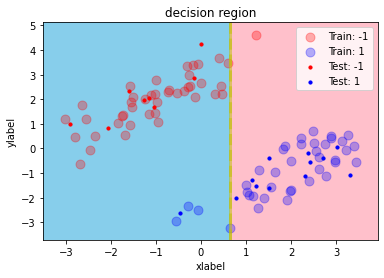

In [34]:
decision_region(x_train,y_train,model, x_test = x_test, y_test = y_test, target_names = ['-1','1'])

Result
Pred:  [ 1 -1  1 -1 -1  1  1 -1  1  1 -1  1 -1 -1  1  1 -1 -1 -1 -1]
[[11  0]
 [ 1  8]]


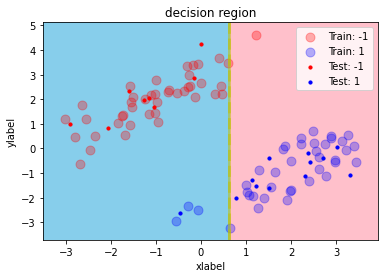

In [35]:
# sklearn's model
from sklearn.tree import DecisionTreeClassifier
sk_model = DecisionTreeClassifier(max_depth = 1, criterion = 'gini')
sk_model.fit(x_train,y_train)
pred = sk_model.predict(x_test)

print('Result')
print('Pred: ', pred.ravel())
print(confusion_matrix(pred,y_test))
decision_region(x_train,y_train,sk_model, x_test = x_test, y_test = y_test, target_names = ['-1','1'])

# Problem 7
Depth 2 Deci Tree

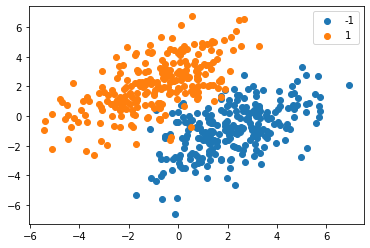

In [36]:
# more complex data set wit more variance
# Data set
np.random.seed(0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[3.0,1.8], [1.8, 3.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])

plt.scatter(X[y==-1][:,0],X[y==-1][:,1], label = '-1')
plt.scatter(X[y==1][:,0],X[y==1][:,1], label = '1')
plt.legend()

Test score:  [[43  0]
 [ 3 54]]


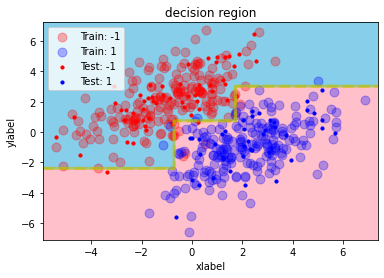

In [37]:
my_model = ScratchDecisionTree(depth=3)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
my_model.fit(x_train,y_train)
y_pred = my_model.predict(x_test)
print('Test score: ',confusion_matrix(y_test, y_pred))
decision_region(x_train,y_train,my_model, x_test = x_test, y_test = y_test, target_names = ['-1','1'])

Test score:  [[43  0]
 [ 3 54]]


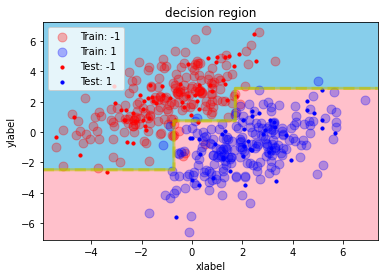

In [38]:
sk_model = DecisionTreeClassifier(max_depth=3,criterion = 'gini')
sk_model.fit(x_train,y_train)
y_pred = sk_model.predict(x_test)
print('Test score: ',confusion_matrix(y_test, y_pred))
decision_region(x_train,y_train,sk_model, x_test = x_test, y_test = y_test, target_names = ['-1','1'])

# Problem 8
Unlimited Depth Deci Tree

-----
Stopping cause cant split any further
Tree depth:  7
Final Tree:  [[[[(-1: -[0 1 2 3]- ),(1: -[]- )],[[(-1: -[]- ),(1: -[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]- )],[[[(-1: -[0 1]- ),(1: -[]- )],[(-1: -[]- ),(1: -[0]- )]],[(-1: -[]- ),(1: -[0 1 2 3]- )]]]],[[[[(-1: -[0 1 2 3 4 5 6]- ),(1: -[]- )],[(-1: -[]- ),(1: -[0]- )]],[[(-1: -[]- ),(1: -[0 1]- )],[(-1: -[0]- ),(1: -[]- )]]],[[[(-1: -[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]- ),(1: -[]- )],[(-1: -[]- ),(1: -[0]- )]],[(-1: -[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 10

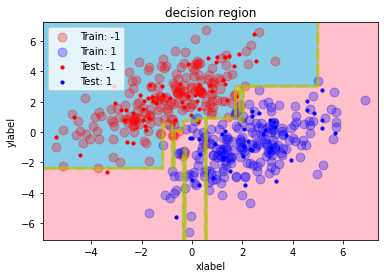

In [41]:
my_model = ScratchDecisionTree(depth=-1, verbose = True)
my_model.fit(x_train,y_train)
y_pred = my_model.predict(x_test)
print('Test score: ',confusion_matrix(y_test, y_pred))
decision_region(x_train,y_train,my_model, x_test = x_test, y_test = y_test, target_names = ['-1','1'])

Train Score:  [[207   0]
 [  0 193]]
Test score:  [[43  0]
 [ 2 55]]


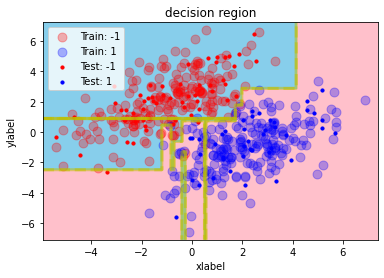

In [49]:
sk_model = DecisionTreeClassifier(max_depth = None, splitter = 'best', criterion = 'gini')
sk_model.fit(x_train,y_train)
y_pred = sk_model.predict(x_test)
print('Train Score: ', confusion_matrix(sk_model.predict(x_train),y_train))
print('Test score: ',confusion_matrix(y_test, y_pred))
decision_region(x_train,y_train,sk_model, x_test = x_test, y_test = y_test, target_names = ['-1','1'])

### Note: Unlimited depth tree
- It seems like in sklearn, there's certain randomness when it comes to choosing which node to check and split first
- That's why in the unlimited depth test, the result of sklearn does vary by a small margin!